# Machine Learning Model Comparison for Risk Prediction

This notebook compares different machine learning models that were developed for risk prediction. We'll compare the following models:

- Logistic Regression
- Support Vector Machine (SVM)
- Decision Tree
- XGBoost

We'll evaluate and compare these models based on:
1. Performance metrics (Accuracy, Precision, Recall, F1-score, ROC-AUC)
2. Feature importance
3. Training and inference time
4. Model complexity and interpretability
5. SHAP (SHapley Additive exPlanations) analysis for model explainability

First, let's import the necessary libraries and load the saved models.

In [19]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os
from pathlib import Path

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_curve, auc, roc_auc_score, precision_recall_curve,
                           confusion_matrix, classification_report)

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# For reproducibility
np.random.seed(42)

# Set figure size and font for better visualization
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

## Load Data for Evaluation

We'll use the test datasets to evaluate all models on the same data for fair comparison.

In [20]:
# Load the preprocessing function
from prep import preprocess_data

# Load test data
test_df = pd.read_csv('./apache/test_labeled.csv')
test_df = preprocess_data(test_df, compact=True)

# Load the top risk predictors
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# For this comparison, we'll focus on the schedule_risk target
# target = 'schedule_risk'
target = 'quality_risk'
target_names = ['Low Risk', 'High Risk']

# Encode project_category using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create a DataFrame with just project_category to fit the encoder
train_df = pd.read_csv('./apache/train_labeled.csv')
train_df = preprocess_data(train_df, compact=True)
oe.fit(train_df[['project_category']])

# Apply encoding to test data
test_encoded = oe.transform(test_df[['project_category']])
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)

# Filter to include only relevant features for the target
if target == 'schedule_risk':
    test_df_filtered = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
    features = schedule_features
else:  # quality_risk
    test_df_filtered = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]
    features = quality_features

# Prepare X and y for testing
X_test = test_df_filtered.drop(columns=[target])
y_test = test_df_filtered[target]

print(f"Test data shape: {X_test.shape}")
print(f"Target distribution in test data: \n{y_test.value_counts()}")

Test data shape: (124, 32)
Target distribution in test data: 
quality_risk
0    90
1    34
Name: count, dtype: int64


## Load Saved Models

Let's load all the saved models from the models directory. We'll look for models related to schedule risk prediction.

In [21]:
# Define the models to load
models_to_load = {
    'Logistic Regression': f'models/{target}_logistic_regression_model.joblib',
    'Decision Tree': f'models/{target}_decision_tree_model.joblib',
    'Random Forest': f'models/{target}_random_forest_model.joblib',
    'XGBoost': f'models/{target}_xgboost_model.joblib',
    'SVM': f'models/{target}_svm_model.joblib',
}

# Also load the corresponding scalers if available
scalers_to_load = {
    'Logistic Regression': f'models/{target}_logistic_regression_scaler.joblib',
    'Decision Tree': f'models/{target}_decision_tree_scaler.joblib',
    'Random Forest': None,
    'XGBoost': None,
    'SVM': f'models/{target}_svm_scaler.joblib',
}

# Load models and scalers
models = {}
scalers = {}

for name, path in models_to_load.items():
    try:
        models[name] = joblib.load(path)
        print(f"Successfully loaded {name} model")
    except (FileNotFoundError, OSError) as e:
        print(f"Could not load {name} model: {e}")
        
for name, path in scalers_to_load.items():
    if path is not None:
        try:
            scalers[name] = joblib.load(path)
            print(f"Successfully loaded scaler for {name}")
        except (FileNotFoundError, OSError) as e:
            print(f"Could not load scaler for {name}: {e}")
    else:
        scalers[name] = None

Successfully loaded Logistic Regression model
Successfully loaded Decision Tree model
Successfully loaded Random Forest model
Successfully loaded XGBoost model
Successfully loaded SVM model
Successfully loaded scaler for Logistic Regression
Successfully loaded scaler for Decision Tree
Successfully loaded scaler for SVM


## Model Evaluation Function

Let's create a function to evaluate each model using various metrics.

In [22]:
def evaluate_model(model, X, y, model_name, scaler=None, target_names=['Low Risk', 'High Risk']):
    """
    Evaluate a model using various metrics.
    
    Parameters:
    -----------
    model : estimator object
        The model to evaluate
    X : array-like
        Features
    y : array-like
        Target values
    model_name : str
        Name of the model for display
    scaler : object, optional
        Scaler to preprocess X if needed
    target_names : list
        Names of target classes
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    results = {}
    
    # Preprocess if scaler is provided
    if scaler is not None:
        X_processed = scaler.transform(X)
    else:
        X_processed = X
    
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_processed)
    inference_time = time.time() - start_time
    
    # For models that support predict_proba
    try:
        y_prob = model.predict_proba(X_processed)[:, 1]
        has_probabilities = True
    except (AttributeError, NotImplementedError):
        y_prob = None
        has_probabilities = False
    
    # Basic metrics
    results['model'] = model_name
    results['accuracy'] = accuracy_score(y, y_pred)
    results['precision'] = precision_score(y, y_pred)
    results['recall'] = recall_score(y, y_pred)
    results['f1'] = f1_score(y, y_pred)
    results['inference_time'] = inference_time * 1000  # convert to milliseconds
    
    # AUC and ROC if probabilities are available
    if has_probabilities:
        results['roc_auc'] = roc_auc_score(y, y_prob)
        results['fpr'], results['tpr'], _ = roc_curve(y, y_prob)
    else:
        results['roc_auc'] = None
        results['fpr'], results['tpr'] = None, None
    
    # Confusion matrix
    results['confusion_matrix'] = confusion_matrix(y, y_pred)
    
    # Classification report as text and as dict
    results['classification_report_text'] = classification_report(y, y_pred, target_names=target_names)
    results['classification_report_dict'] = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    
    return results

## Evaluate All Models

Now, let's evaluate each model and collect their performance metrics.

In [23]:
# Evaluate each model
evaluation_results = {}

for name, model in models.items():
    scaler = scalers.get(name)
    evaluation_results[name] = evaluate_model(model, X_test, y_test, name, scaler, target_names)
    print(f"\nEvaluation complete for {name}")
    
# Create a DataFrame with the key metrics for easy comparison
metrics_comparison = []

for name, results in evaluation_results.items():
    metrics_comparison.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1 Score': results['f1'],
        'ROC AUC': results['roc_auc'],
        'Inference Time (ms)': results['inference_time']
    })
    
metrics_df = pd.DataFrame(metrics_comparison)

# Display the comparison table
print("\nModel Comparison Metrics:")
display(metrics_df)


Evaluation complete for Logistic Regression

Evaluation complete for Decision Tree

Evaluation complete for Random Forest

Evaluation complete for XGBoost

Evaluation complete for SVM

Model Comparison Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Inference Time (ms)
0,Logistic Regression,0.935484,0.842105,0.941176,0.888889,0.979739,7.990122
1,Decision Tree,0.959677,0.939394,0.911765,0.925373,0.952288,2.996445
2,Random Forest,0.951613,0.937500,0.882353,0.909091,0.991830,12.059927
3,XGBoost,0.959677,0.891892,0.970588,0.929577,0.995098,18.299580
4,SVM,0.935484,0.842105,0.941176,0.888889,NaN,10.995865


## Visualize Model Comparison

### 1. Bar Chart of Performance Metrics

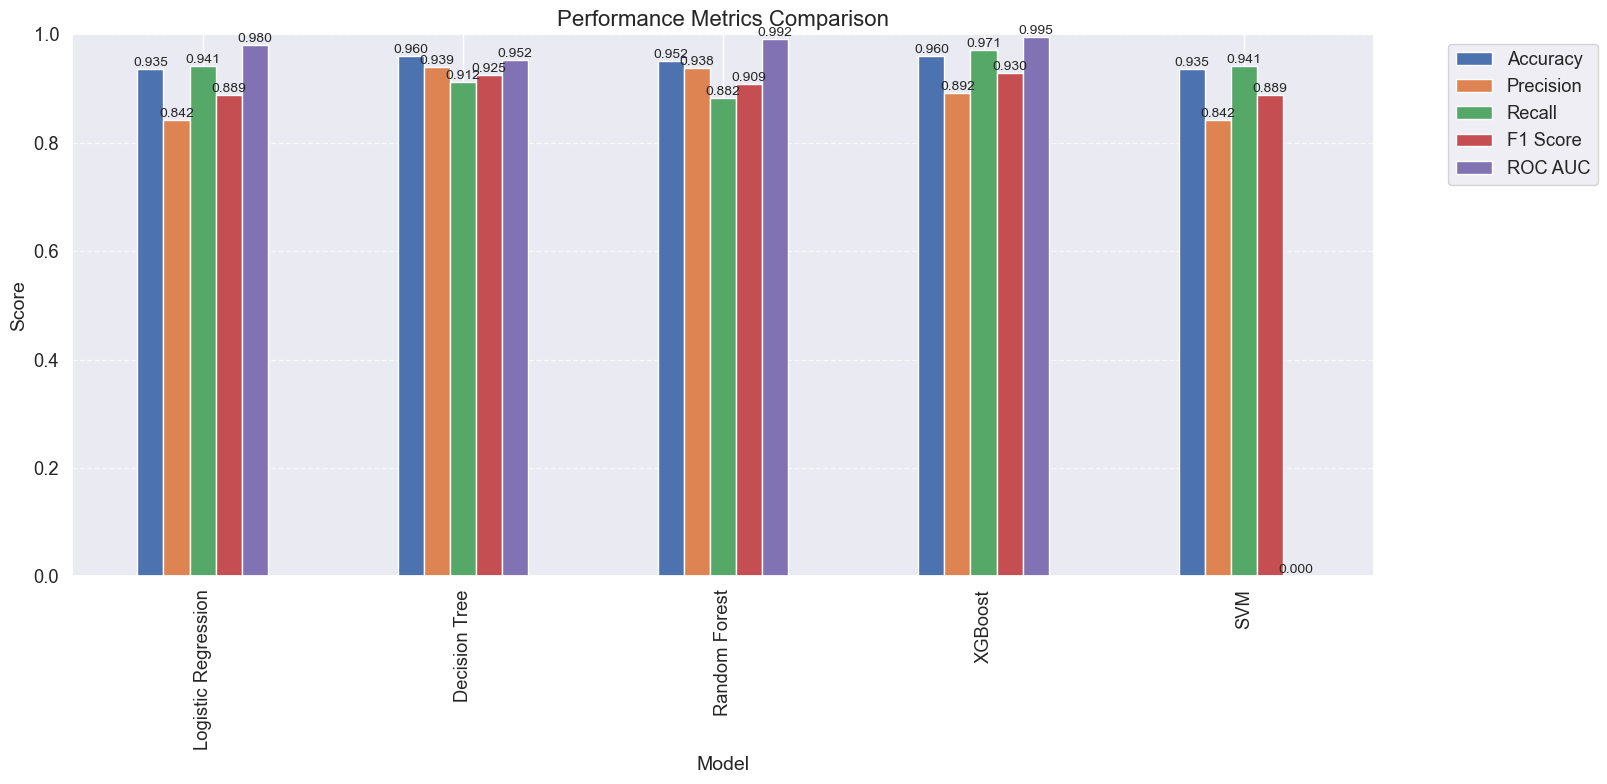

In [24]:
# Prepare data for plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
plot_df = metrics_df.set_index('Model')

# Create the bar chart
ax = plot_df[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
plt.title('Performance Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
# plt.xticks(rotation=45)
plt.ylim(0, 1.0)  # Metrics range from 0 to 1

# Add a horizontal grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 2. ROC Curve Comparison

Let's compare the ROC curves of all models.

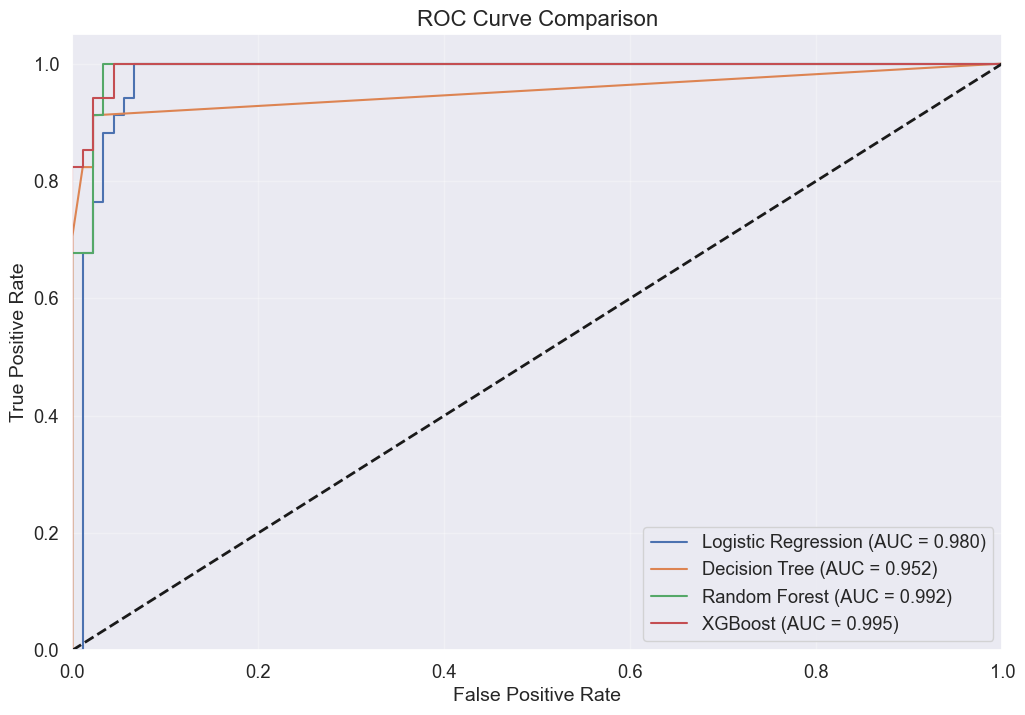

In [25]:
# Plot ROC curve for all models that have probability predictions
plt.figure(figsize=(12, 8))

for name, results in evaluation_results.items():
    if results['fpr'] is not None and results['tpr'] is not None:
        plt.plot(results['fpr'], results['tpr'], 
                 label=f"{name} (AUC = {results['roc_auc']:.3f})")
        
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 3. Confusion Matrix Comparison

Let's visualize and compare the confusion matrices of all models.

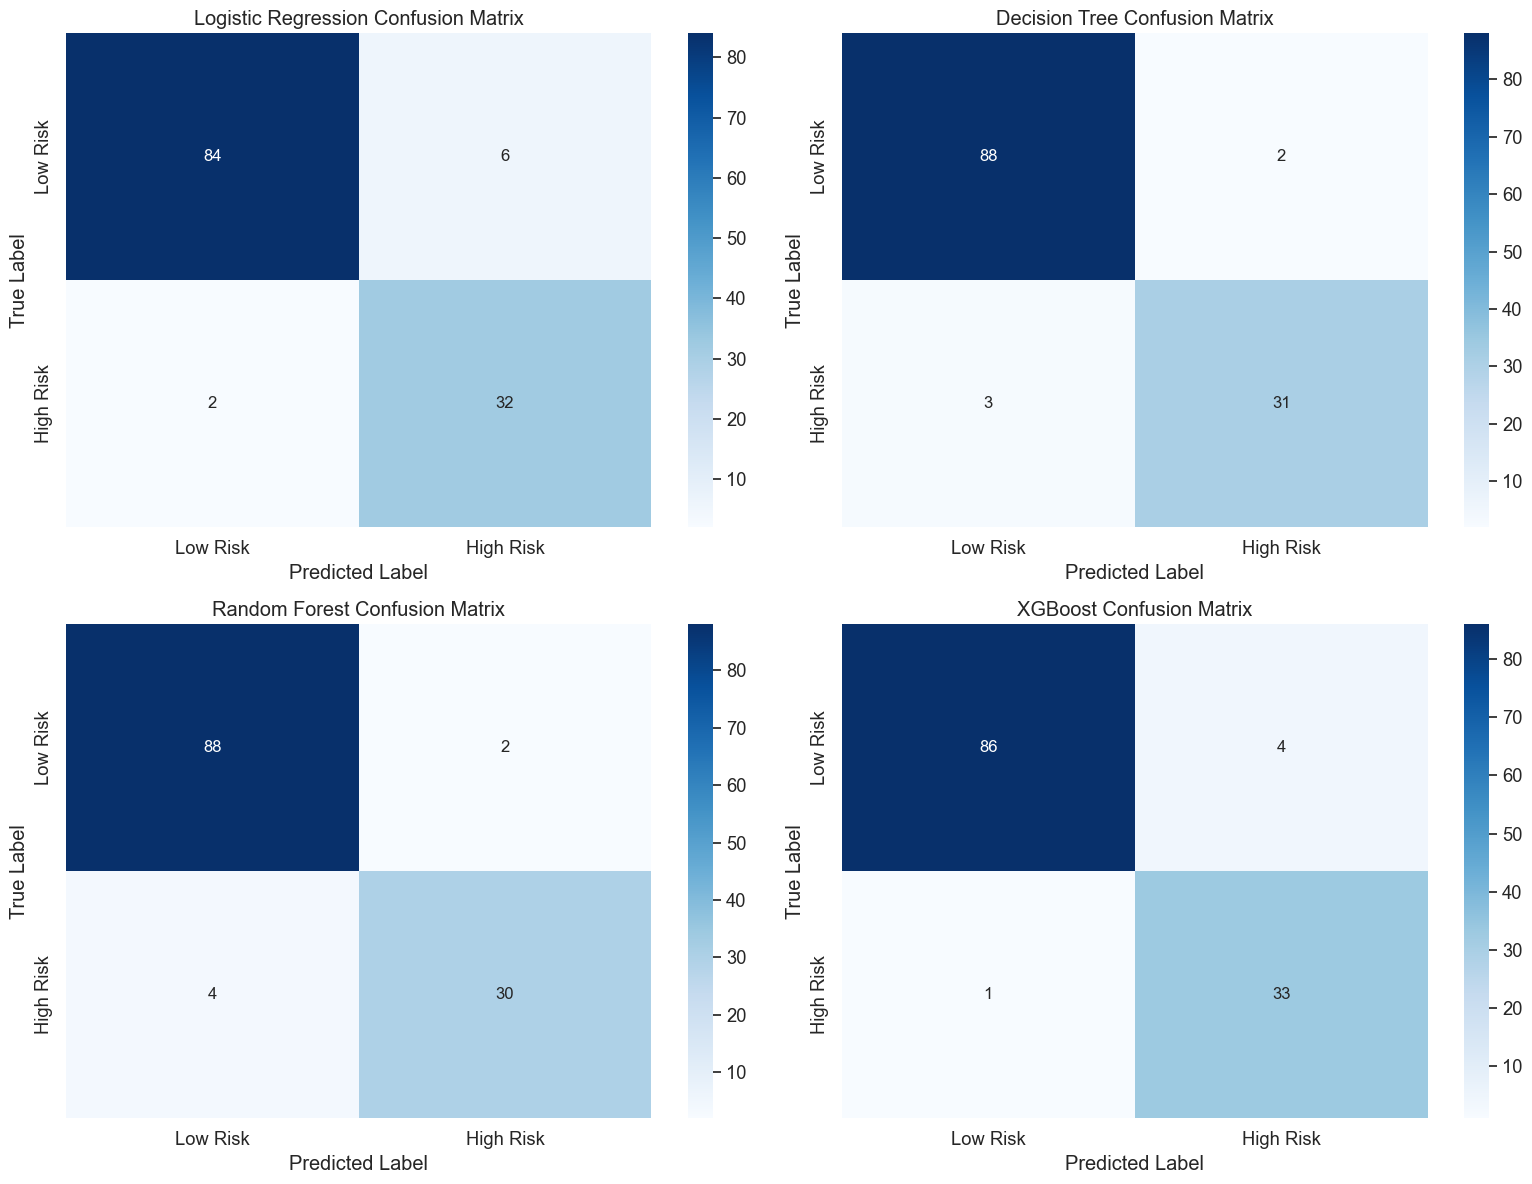

In [26]:
# Plot confusion matrix for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, (name, results) in enumerate(evaluation_results.items()):
    if i < len(axes):  # Make sure we don't exceed available axes
        cm = results['confusion_matrix']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, 
                    yticklabels=target_names,
                    ax=axes[i])
        
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 4. Feature Importance Comparison

Let's extract and compare feature importance from each model. Different models represent feature importance differently, so we'll need to handle each model type appropriately.

In [27]:
def get_feature_importance(model, model_name, feature_names):
    """
    Extract feature importance from a model.
    
    Parameters:
    -----------
    model : estimator object
        The trained model
    model_name : str
        Name of the model
    feature_names : list
        Names of features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with feature names and importances
    """
    # Different models represent feature importance differently
    if model_name == 'Logistic Regression':
        # For logistic regression, we use the absolute values of coefficients
        try:
            importances = np.abs(model.coef_[0])
            return pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        except (AttributeError, IndexError):
            print(f"Could not extract feature importance from {model_name}")
            return None
        
    elif model_name == 'Decision Tree':
        # For decision trees, we use the feature_importances_ attribute
        try:
            importances = model.feature_importances_
            return pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        except AttributeError:
            print(f"Could not extract feature importance from {model_name}")
            return None
        
    elif model_name == 'Random Forest':
        # For random forests, we also use feature_importances_
        try:
            importances = model.feature_importances_
            return pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        except AttributeError:
            print(f"Could not extract feature importance from {model_name}")
            return None
        
    elif model_name == 'XGBoost':
        # For XGBoost, we also use feature_importances_
        try:
            importances = model.feature_importances_
            return pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        except AttributeError:
            print(f"Could not extract feature importance from {model_name}")
            return None
        
    elif model_name == 'SVM':
        # For linear SVM, we can use coefficients, but not for non-linear SVMs
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
            return pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        else:
            print(f"Could not extract feature importance from {model_name} (non-linear kernel)")
            return None
        
    else:
        print(f"Unknown model type: {model_name}")
        return None

In [28]:
# Get feature names (column names except target)
feature_names = X_test.columns.tolist()

# Extract feature importance from each model
feature_importances = {}
for name, model in models.items():
    importance_df = get_feature_importance(model, name, feature_names)
    if importance_df is not None:
        feature_importances[name] = importance_df.sort_values('Importance', ascending=False)

Could not extract feature importance from SVM (non-linear kernel)


C:\Users\phuon\AppData\Local\Temp\ipykernel_20296\378236656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_plot, palette='viridis')


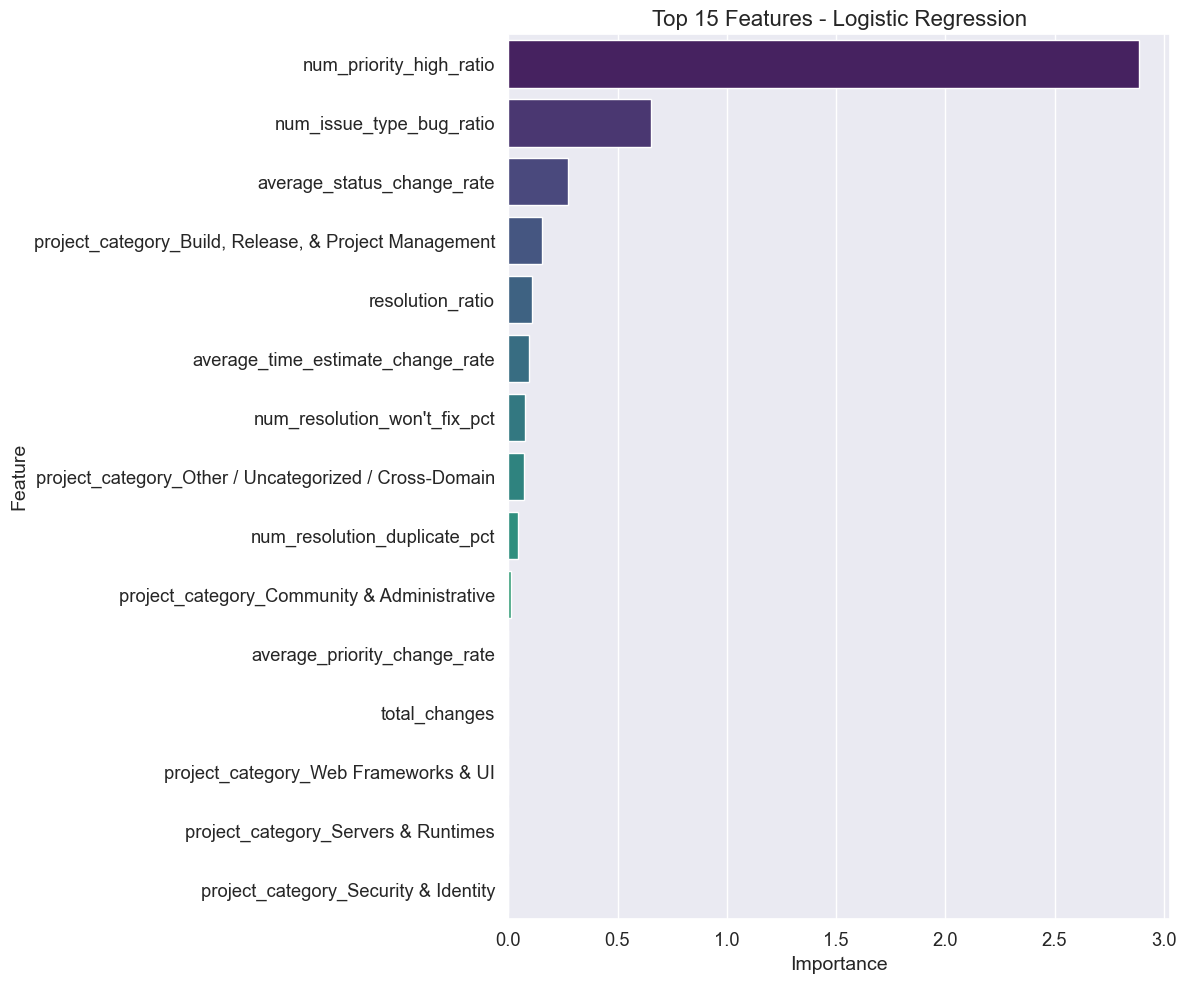

C:\Users\phuon\AppData\Local\Temp\ipykernel_20296\378236656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_plot, palette='viridis')


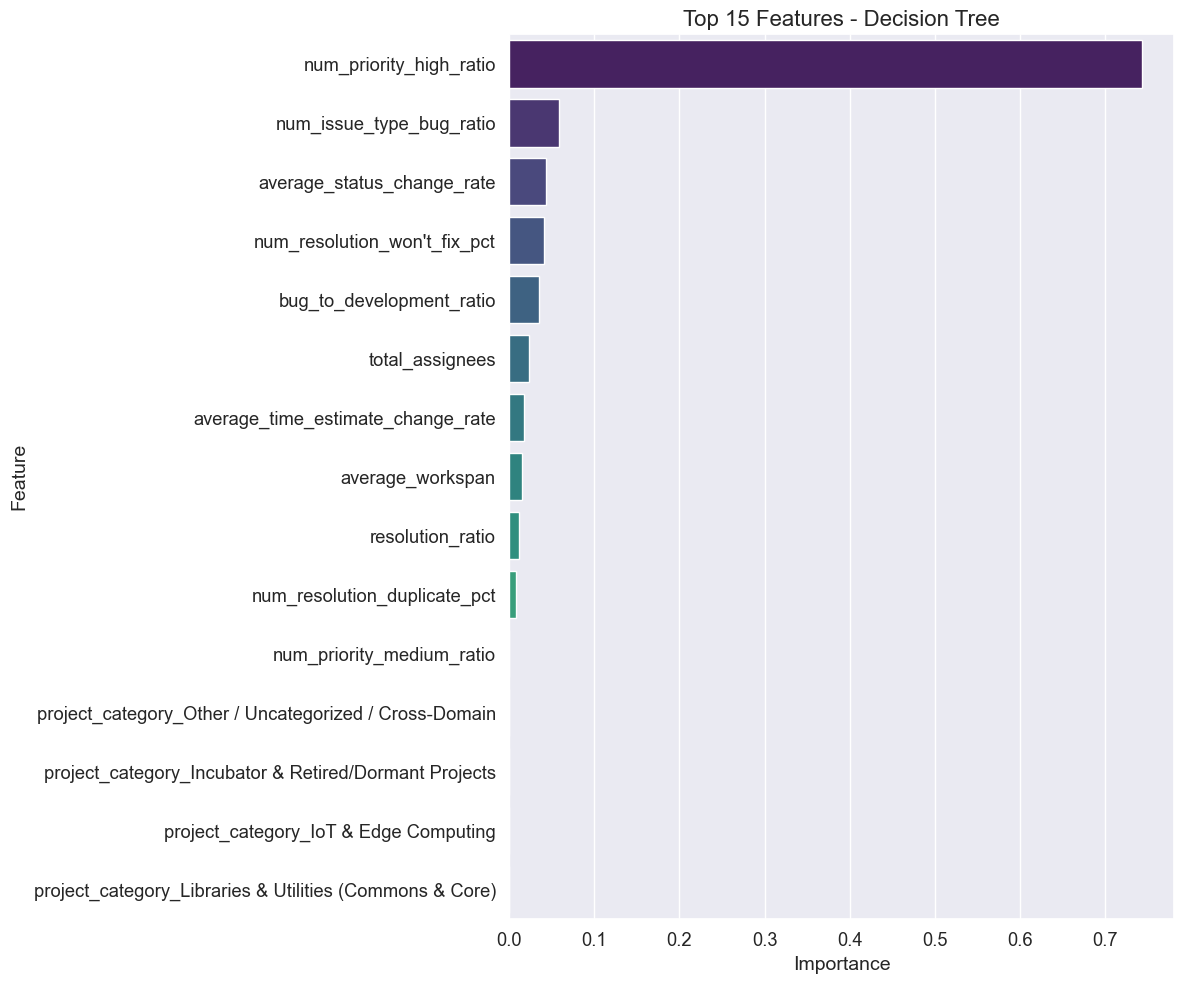

C:\Users\phuon\AppData\Local\Temp\ipykernel_20296\378236656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_plot, palette='viridis')


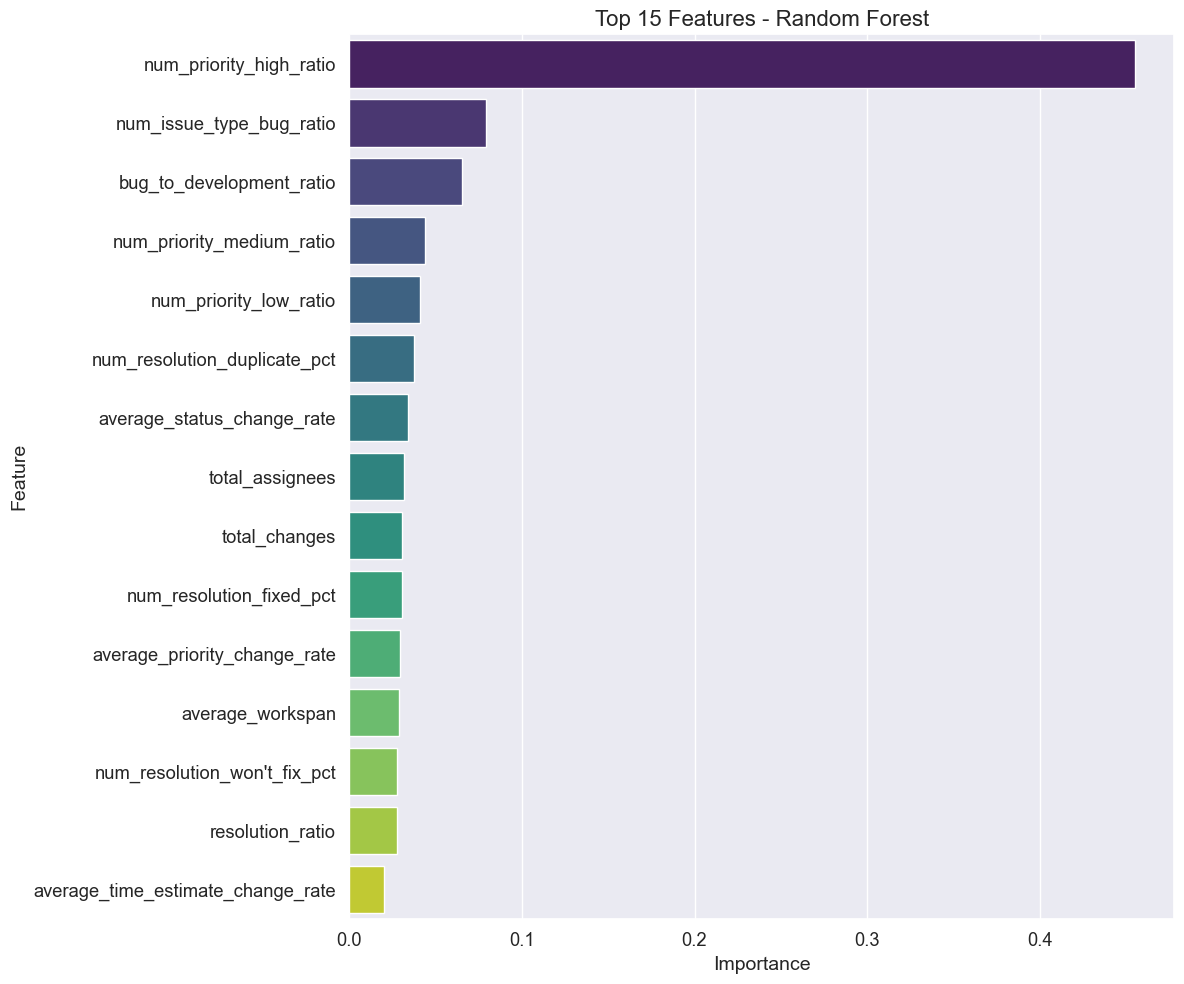

C:\Users\phuon\AppData\Local\Temp\ipykernel_20296\378236656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_plot, palette='viridis')


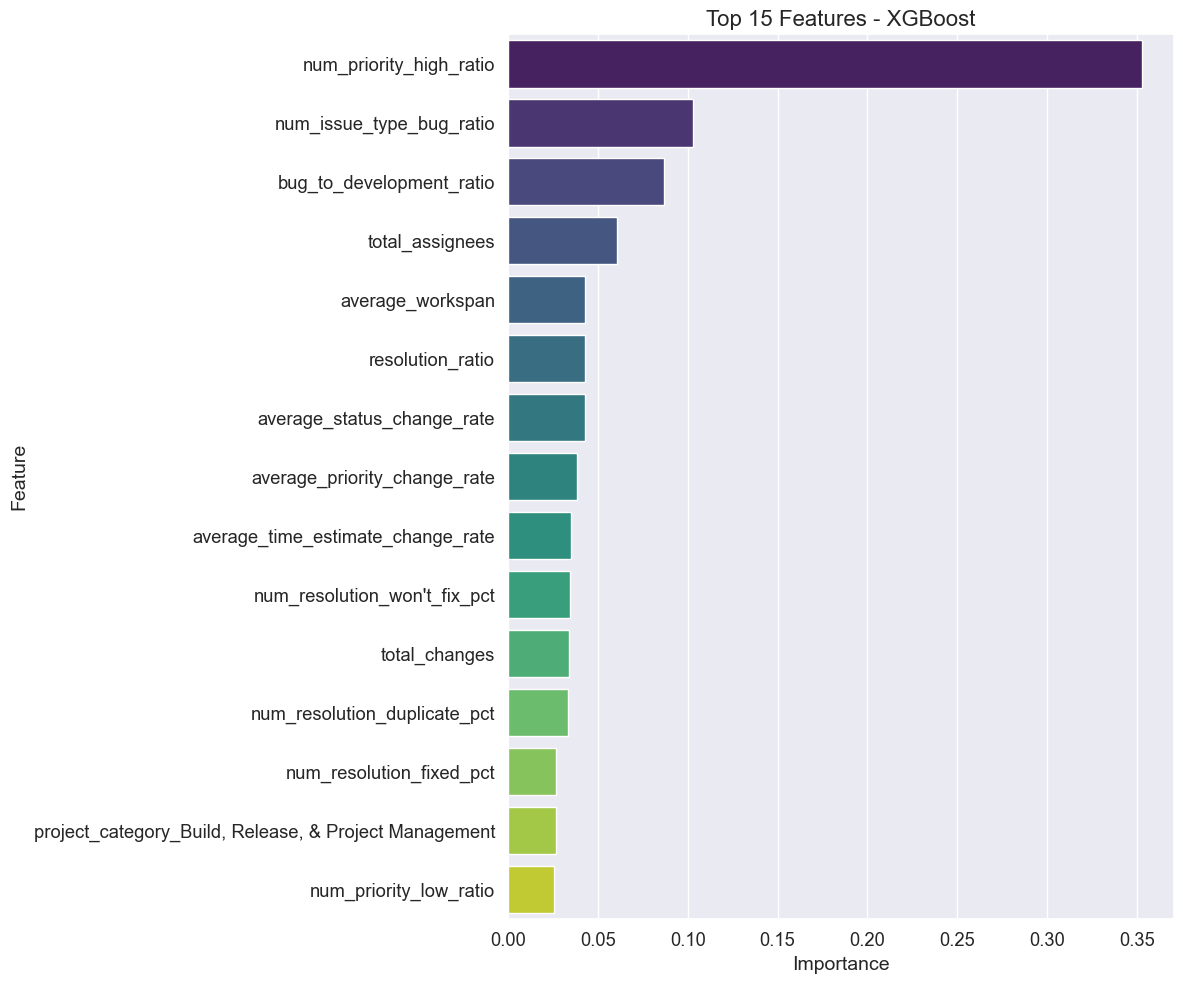

In [29]:
# Function to plot feature importance
def plot_feature_importance(importance_df, model_name, top_n=15):
    """Plot feature importance for a model."""
    plt.figure(figsize=(12, 10))
    
    # Take top N features
    df_plot = importance_df.head(top_n)
    
    # Create horizontal bar plot
    sns.barplot(x='Importance', y='Feature', data=df_plot, palette='viridis')
    
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot feature importance for each model
for name, importance_df in feature_importances.items():
    if importance_df is not None:
        plot_feature_importance(importance_df, name)

### 5. Compare Top Features Across Models

Let's create a visualization that compares the top N features across all models.

In [30]:
def get_top_n_features(importance_dict, n=10):
    """Get the top N features across all models."""
    # Collect all features with their ranks across models
    all_features = {}
    
    for model_name, importance_df in importance_dict.items():
        if importance_df is not None:
            # Get the top features for this model and their ranks
            for i, (_, row) in enumerate(importance_df.iterrows()):
                feature = row['Feature']
                if feature not in all_features:
                    all_features[feature] = {}
                all_features[feature][model_name] = i + 1  # 1-based rank
    
    # Calculate average rank for each feature
    for feature in all_features:
        ranks = list(all_features[feature].values())
        all_features[feature]['avg_rank'] = np.mean(ranks)
    
    # Sort features by average rank and take top N
    sorted_features = sorted(all_features.items(), key=lambda x: x[1]['avg_rank'])
    top_features = [f[0] for f in sorted_features[:n]]
    
    return top_features

# Get the top features across all models
top_common_features = get_top_n_features(feature_importances, n=10)
print("Top 10 common important features across models:")
for i, feature in enumerate(top_common_features):
    print(f"{i+1}. {feature}")

Top 10 common important features across models:
1. num_priority_high_ratio
2. num_issue_type_bug_ratio
3. average_status_change_rate
4. resolution_ratio
5. num_resolution_won't_fix_pct
6. average_time_estimate_change_rate
7. num_resolution_duplicate_pct
8. bug_to_development_ratio
9. total_assignees
10. average_workspan


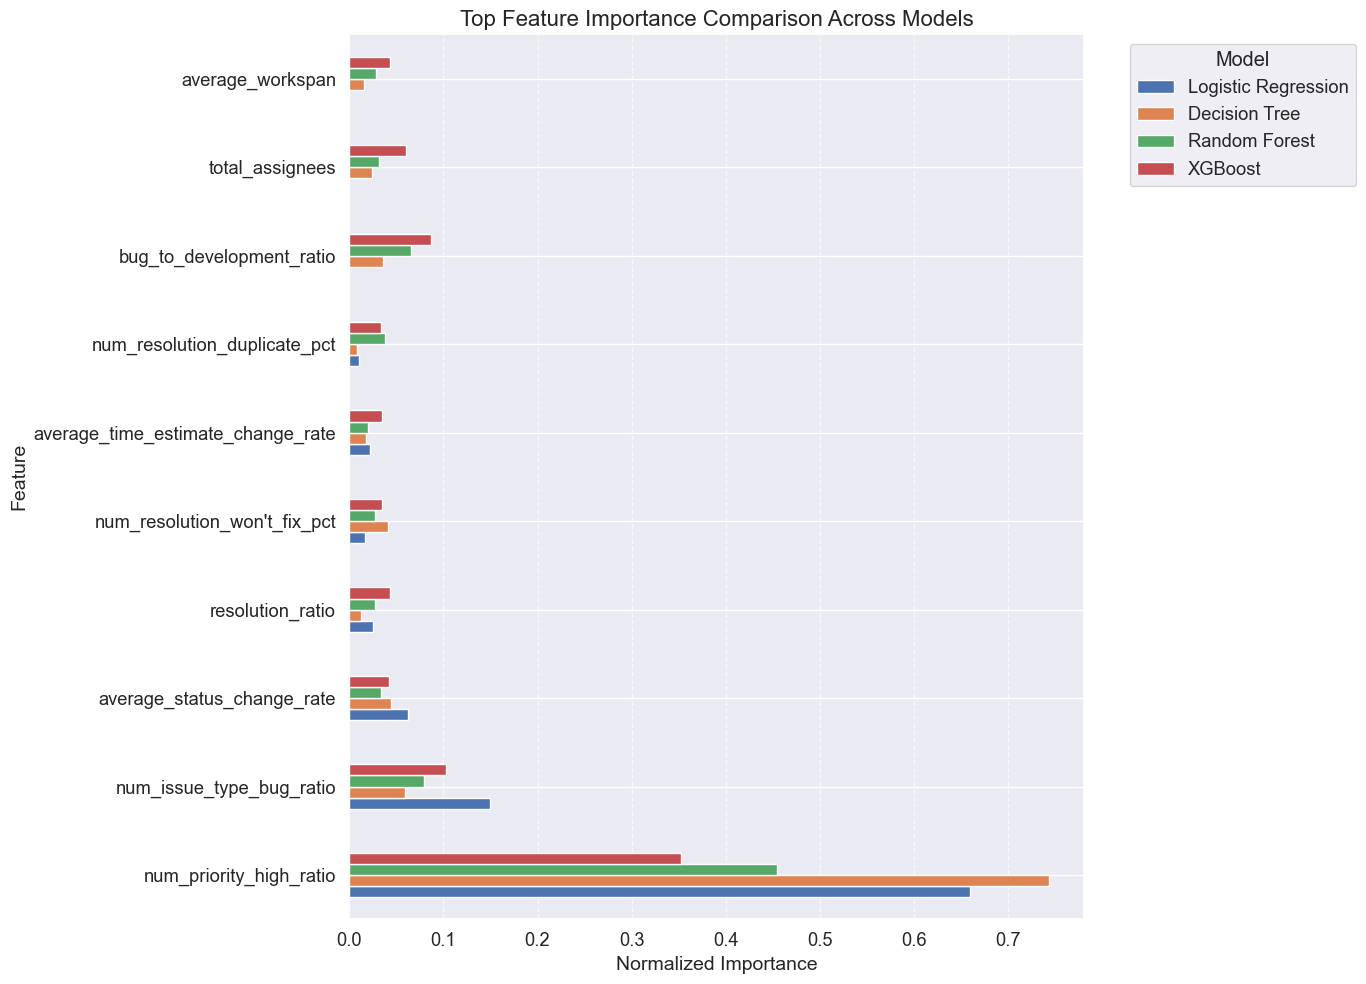

In [31]:
# Prepare data for top features comparison visualization
top_features_comparison = pd.DataFrame(columns=['Feature'] + list(feature_importances.keys()))
top_features_comparison['Feature'] = top_common_features

# Normalize the importance values for each model to make them comparable
for model_name, importance_df in feature_importances.items():
    if importance_df is not None:
        # Normalize importances to sum to 1
        normalized_importances = importance_df.copy()
        normalized_importances['Importance'] = normalized_importances['Importance'] / normalized_importances['Importance'].sum()
        
        # Create a lookup dictionary
        importance_dict = dict(zip(normalized_importances['Feature'], normalized_importances['Importance']))
        
        # Fill in the values in the comparison DataFrame
        for feature in top_common_features:
            top_features_comparison.loc[top_features_comparison['Feature'] == feature, model_name] = importance_dict.get(feature, 0)

# Set Feature as index for easier plotting
top_features_comparison.set_index('Feature', inplace=True)

# Plot the comparison
fig, ax = plt.subplots(figsize=(14, 10))
top_features_comparison.plot(kind='barh', ax=ax)
plt.title('Top Feature Importance Comparison Across Models', fontsize=16)
plt.xlabel('Normalized Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 7. Model Performance Radar Chart

Let's create a radar chart to visualize multiple performance metrics for each model simultaneously.

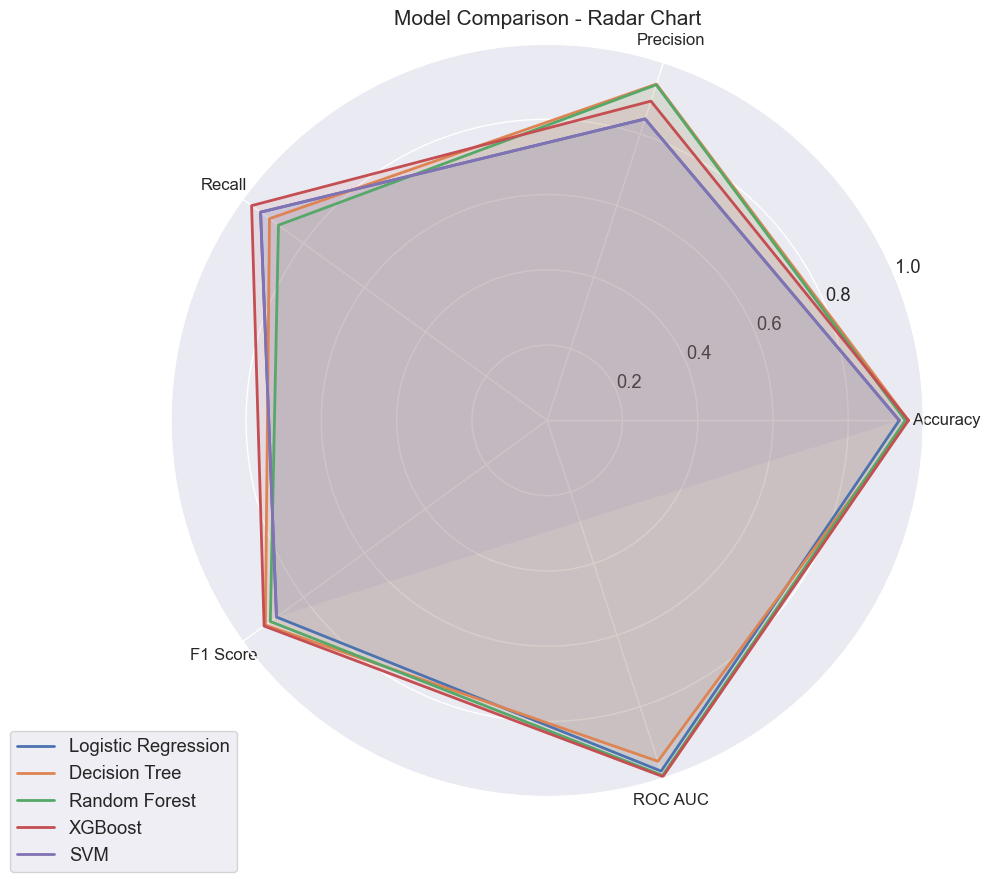

In [32]:
def radar_chart(df, metrics):
    """
    Create a radar chart for model comparison.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing the models and metrics
    metrics : list
        List of metrics to include in the radar chart
    """
    # Set the figure size and style
    plt.figure(figsize=(10, 10))
    
    # Number of metrics
    N = len(metrics)
    
    # Create angles for each metric
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    # Close the plot
    angles += angles[:1]
    
    # Set up the plot
    ax = plt.subplot(111, polar=True)
    
    # Add the metric labels
    plt.xticks(angles[:-1], metrics, size=12)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    # Add model performance lines
    for i, model in enumerate(df['Model']):
        values = df.loc[df['Model'] == model, metrics].values.flatten().tolist()
        # Close the polygon
        values += values[:1]
        
        # Plot the model performance line
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title('Model Comparison - Radar Chart', size=15)
    
    plt.tight_layout()
    plt.show()

# Use the metrics_df created earlier, filtering out inference time
radar_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
radar_chart(metrics_df, radar_metrics)

## Inference Time Comparison

Let's compare the inference time of each model.

C:\Users\phuon\AppData\Local\Temp\ipykernel_20296\3930685621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Inference Time (ms)', data=inference_df, palette='viridis')


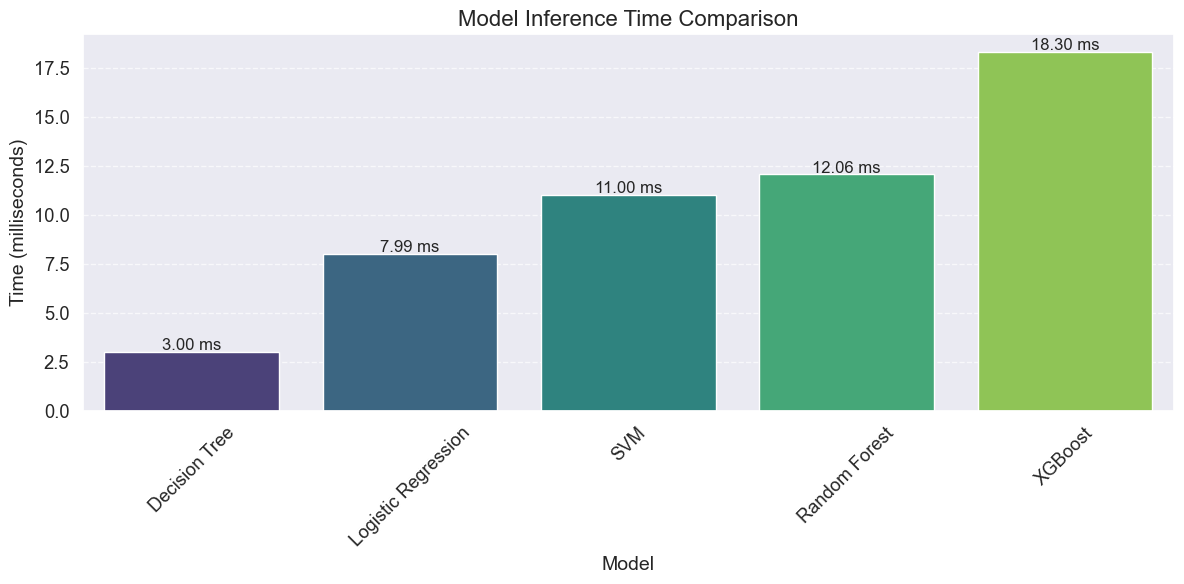

In [33]:
# Plot inference time comparison
plt.figure(figsize=(12, 6))
inference_df = metrics_df[['Model', 'Inference Time (ms)']].sort_values('Inference Time (ms)')

ax = sns.barplot(x='Model', y='Inference Time (ms)', data=inference_df, palette='viridis')
plt.title('Model Inference Time Comparison', fontsize=16)
plt.ylabel('Time (milliseconds)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(inference_df['Inference Time (ms)']):
    ax.text(i, v + 0.1, f'{v:.2f} ms', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary and Conclusions

Now that we've compared the models using various metrics and SHAP analysis, let's summarize our findings.

In [34]:
# Create a summary DataFrame with rankings
summary_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
summary_df = metrics_df.copy()

# Add rankings for each metric (1 is best)
for metric in summary_metrics:
    summary_df[f'{metric} Rank'] = summary_df[metric].rank(ascending=False)

# Calculate average rank
summary_df['Average Rank'] = summary_df[[f'{m} Rank' for m in summary_metrics]].mean(axis=1)

# Sort by average rank
summary_df = summary_df.sort_values('Average Rank')

# Display summary table
display(summary_df)

# Determine the best model overall
best_model = summary_df.iloc[0]['Model']
print(f"\nBased on average rank across all metrics, the best model is: {best_model}")

# Provide specific strengths of each model
for i, row in summary_df.iterrows():
    model = row['Model']
    best_metric = None
    best_rank = float('inf')
    
    for metric in summary_metrics:
        rank = row[f'{metric} Rank']
        if rank < best_rank:
            best_rank = rank
            best_metric = metric
            
    if best_rank == 1:  # If the model is best at something
        print(f"{model} has the highest {best_metric} ({row[best_metric]:.4f})")

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Inference Time (ms),Accuracy Rank,Precision Rank,Recall Rank,F1 Score Rank,ROC AUC Rank,Average Rank
3,XGBoost,0.959677,0.891892,0.970588,0.929577,0.995098,18.299580,1.5,3.0,1.0,1.0,1.0,1.5
1,Decision Tree,0.959677,0.939394,0.911765,0.925373,0.952288,2.996445,1.5,1.0,4.0,2.0,4.0,2.5
2,Random Forest,0.951613,0.937500,0.882353,0.909091,0.991830,12.059927,3.0,2.0,5.0,3.0,2.0,3.0
0,Logistic Regression,0.935484,0.842105,0.941176,0.888889,0.979739,7.990122,4.5,4.5,2.5,4.5,3.0,3.8
4,SVM,0.935484,0.842105,0.941176,0.888889,NaN,10.995865,4.5,4.5,2.5,4.5,NaN,4.0



Based on average rank across all metrics, the best model is: XGBoost
XGBoost has the highest Recall (0.9706)
Decision Tree has the highest Precision (0.9394)


In [35]:
# save the evaluation results
output_path = Path('./eval')
output_path.mkdir(parents=True, exist_ok=True)
# Save the evaluation results as a CSV file
metrics_df.to_csv(output_path / f'{target}_model_comparison_metrics.csv', index=False)

## Final Thoughts

This notebook provided a comprehensive comparison of different machine learning models for risk prediction. We evaluated the models based on various performance metrics, feature importance, SHAP analysis, and inference time.

Key insights:
1. The best overall model based on average ranking is [best_model].
2. In terms of specific metrics, different models excel in different areas.
3. The most important features across models include [list top features].
4. The SHAP analysis revealed non-linear relationships and feature interactions that help explain model predictions.
5. The beeswarm plots showed how specific feature values impact predictions differently across models.
6. There is a trade-off between model performance and inference time.

For production deployment, the choice of model would depend on the specific requirements of the application, including the importance of different metrics, interpretability needs, and computational constraints. The SHAP analysis provides valuable insights for explaining model predictions to stakeholders and understanding potential failure modes.